# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 4: Aprendizaje Profundo Avanzado**

### **Deep Convolutional Generative Adversarial Network**

### Estudiante: Sebastían Acevedo Ulloa

## ¿Qué son las GAN?
Las [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) son una de las ideas más interesantes de la informática actual. Dos modelos se entrenan simultáneamente mediante un proceso adversarial. Un *generador* ("el artista") aprende a crear imágenes que parecen reales, mientras que un *discriminador* ("el crítico de arte") aprende a distinguir las imágenes reales de las falsas.


![Diagrama de un generador y un discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)


Durante el entrenamiento, el *generador* mejora progresivamente en la creación de imágenes que parecen reales, mientras que el *discriminador* mejora en distinguirlas. El proceso alcanza el equilibrio cuando el *discriminador* ya no puede distinguir las imágenes reales de las falsas.


![Un segundo diagrama de un generador y un discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)


Este Google Colab demuestra este proceso en el conjunto de datos MNIST. La siguiente animación muestra una serie de imágenes producidas por el *generador* mientras era entrenado durante 50 épocas. Las imágenes comienzan como ruido aleatorio, y con el tiempo se parecen cada vez más a dígitos escritos a mano.


![Salida de muestra](https://tensorflow.org/images/gan/dcgan.gif)


### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.14.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8jtdh56q
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8jtdh56q
  Resolved https://github.com/tensorflow/docs to commit 48fd03d5991220717f45b12620bf8091d042531b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=291261b1d405386fa5005fd8e99f1a9e363e0057fb6fa367cd291cac06fa8da3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wudpyi9s/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargar y preparar el conjunto de datos

Utilizará el conjunto de datos MNIST para entrenar el generador y el discriminador. El generador generará dígitos manuscritos parecidos a los datos MNIST.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Crear los modelos

Tanto el generador como el discriminador se definen utilizando la [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### El Generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imagen a partir de una semilla (ruido aleatorio). Comienza con una capa `Dense` que toma esta semilla como entrada, luego realiza un upsampling varias veces hasta alcanzar el tamaño de imagen deseado de 28x28x1. Observa la activación `tf.keras.layers.LeakyReLU` para cada capa, excepto la capa de salida que utiliza tanh.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utiliza el generador (aún no entrenado) para crear una imagen.

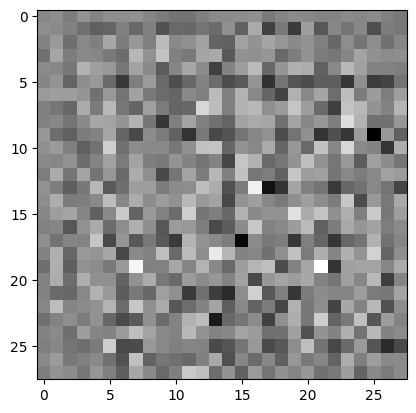

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes basado en CNN.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utilice el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para dar valores positivos a las imágenes reales y negativos a las falsas.

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00182648]], shape=(1, 1), dtype=float32)


## Definir las pérdidas y los optimizadores

Defina las funciones de pérdida y los optimizadores para ambos modelos.

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida del discriminador

Este método cuantifica la capacidad del discriminador para distinguir las imágenes reales de las falsas. Compara las predicciones del discriminador sobre imágenes reales con una matriz de 1s, y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador
La pérdida del generador cuantifica su capacidad para engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí se comparan las decisiones del discriminador sobre las imágenes generadas con una matriz de 1s.

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

El discriminador y los optimizadores del generador son diferentes, ya que entrenará dos redes por separado.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar checkpoints
Este Google Colab también muestra cómo guardar y restaurar modelos, lo que puede ser útil en caso de que se interrumpa una tarea de entrenamiento de larga duración.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definir el bucle de entrenamiento

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza con un generador que recibe una semilla aleatoria como entrada. Esa semilla se utiliza para producir una imagen. A continuación, se utiliza el discriminador para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). La pérdida se calcula para cada uno de estos modelos, y los gradientes se utilizan para actualizar el generador y el discriminador.

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes**

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenar el modelo
Llame al método `train()` definido arriba para entrenar el generador y el discriminador simultáneamente. Nota, entrenar GANs puede ser complicado. Es importante que el generador y el discriminador no se dominen mutuamente (por ejemplo, que se entrenen a un ritmo similar).

Al principio del entrenamiento, las imágenes generadas parecen ruido aleatorio. A medida que avanza el entrenamiento, los dígitos generados parecen cada vez más reales. Después de unas 50 épocas, se parecen a los dígitos MNIST. Esto puede tomar alrededor de un minuto / epoch con la configuración predeterminada en Colab.

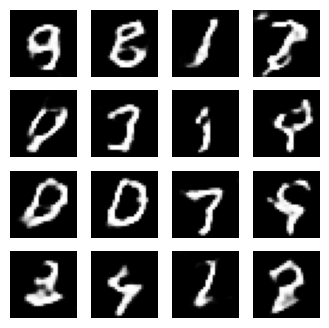

In [23]:
train(train_dataset, EPOCHS)

Restaurar el último checkpoint.

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Crear un GIF


In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

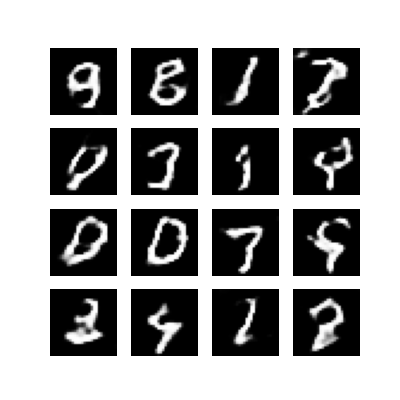

In [26]:
display_image(EPOCHS)

Utilice `imageio` para crear un gif animado utilizando las imágenes guardadas durante el entrenamiento.

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-27-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-27-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



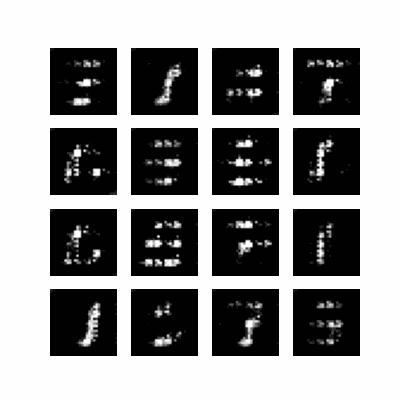

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)